In [ ]:
'''
* Works best for high volume, high activity stocks (pre-market movers, historically high volume stocks, etc.)
* Define a breakout rule - for ex: 20 period rolling max/min price as
* well as volume breaching rolling max volume 
    - then long/short based on the signals
* Exit and stop loss signals: 
    - ex - previous close price +/- 20 period ATR as rolling stop loss price 
'''
'''
| Situation                  | What to Report                               |
| -------------------------- | -------------------------------------------- |
| Intraday or 1-day backtest | Show raw return and Sharpe (with disclaimer) |
| 1–4 weeks of data          | Report both raw and annualized return        |
| >3 months                  | Annualized metrics are more trustworthy      |
'''

# For now, handling missing data by forward filling 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import copy

def raw_return(input_df):
    df = input_df.copy()
    df['Cumulative Return'] = (1 + df['Return']).cumprod()

def CAGR(input_df):
    df = input_df.copy()
    df['Cumulative Return'] = (1 + df['Return']).cumprod()
    n = len(df)/(252*78)  # Assuming num_days trading days per and 78 5-minute candles per day
    cagr = (df['Cumulative Return'].iloc[-1]) ** (1 / n) - 1
    return cagr.item()

def avg_return(input_df):
    return input_df['Return'].mean() * 252 * 78  # Annualized average return

def volatility(input_df):
    df = input_df.copy()
    vol = df['Return'].std() * ((252*78) ** 0.5)  # Annualized volatility
    return vol

def sharpe(input_df, risk_free_rate=0.025):
    df = input_df.copy()
    if volatility(df) == 0:
        return pd.Series([float('nan') for _ in range(len(df))])
    sharpe_ratio = (avg_return(df) - risk_free_rate) / volatility(df)  # Annualized Sharpe Ratio
    return sharpe_ratio

def raw_sharpe(input_df, risk_free_rate=0.025):
    df = input_df.copy()
    if df['Return'].std() == 0:
        return pd.Series([float('nan') for _ in range(len(df))])
    raw_sharpe_ratio = (df['Return'].mean() - risk_free_rate) / df['Return'].std()  # Raw Sharpe Ratio
    return raw_sharpe_ratio

def ATR(input_df, period=20):
    df = input_df.copy()
    df['High-Low'] = df['High'] - df['Low']
    df['High-Prev Close'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-Prev Close'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-Prev Close', 'Low-Prev Close']].max(axis=1, skipna=True)
    df['ATR'] = df['TR'].rolling(window=period).mean()
    return df['ATR']

In [20]:
import yfinance as yf 

def get_intraday_data(ticker_symbol, period="1mo", interval="5m"):
    """
    Retrieves intraday stock data from Yahoo Finance.

    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., "AAPL").
        period (str, optional): The period for data retrieval (e.g., "1d", "5d", "1wk"). Defaults to "1d".
        interval (str, optional): The interval between data points (e.g., "1m", "2m", "5m", "15m", "30m", "60m"). Defaults to "1m".

    Returns:
        pandas.DataFrame: A DataFrame containing the intraday data, or None if an error occurs.
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        data = ticker.history(period=period, interval=interval, auto_adjust=False)
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None

# ticker_symbol = "AAPL"
# intraday_data = get_intraday_data(ticker_symbol, period="5d", interval="15m")
# print(intraday_data.head())
# print(intraday_data.columns)

def get_data(tickers):
    ohlc_intraday = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = get_intraday_data(ticker)
        df.dropna(inplace=True)
        ohlc_intraday[ticker] = df

    # Step 2: Create a full index across all tickers
    all_indices = set()
    for df in ohlc_intraday.values():
        all_indices.update(df.index)
    full_index = sorted(all_indices)

    # Step 3: Reindex and fill missing rows for each ticker
    for ticker in tickers:
        if ticker in ohlc_intraday:
            df = ohlc_intraday[ticker].reindex(full_index)
            df.ffill(inplace=True)
            df.bfill(inplace=True)
            ohlc_intraday[ticker] = df

    return ohlc_intraday

# # Usually for tech stocks
tickers = ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'INTC', 'CSCO', 'TSLA', 'HTZ', 'VZ', 'FB', 'ABVE'] # took out FB and ABVE bc some missing data
ohlc_intraday = get_data(tickers)
# print(ohlc_mon['NVDA'])

Fetching data for NVDA...
Fetching data for MSFT...


Fetching data for AAPL...
Fetching data for AMZN...
Fetching data for INTC...
Fetching data for CSCO...
Fetching data for TSLA...
Fetching data for HTZ...
Fetching data for VZ...
Fetching data for FB...
Fetching data for ABVE...


In [21]:
len(ohlc_intraday['ABVE'])

1524

In [22]:
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {} # Stores the signal for each ticker (buy or sell) for a given time 
tickers_ret = {} # Stores the returns for each ticker over time 

for ticker in tickers:
    print("Calculating signals for:", ticker)
    ohlc_dict[ticker]['ATR'] = ATR(ohlc_dict[ticker], period=20)
    ohlc_dict[ticker]['Rolling Max Close Price'] = ohlc_dict[ticker]['Adj Close'].rolling(window=20).max()
    ohlc_dict[ticker]['Rolling Min Close Price'] = ohlc_dict[ticker]['Adj Close'].rolling(window=20).min()
    ohlc_dict[ticker]['Rolling Max Volume'] = ohlc_dict[ticker]['Volume'].rolling(window=20).max()
    # print(f"{ticker} before dropna: {len(ohlc_intraday[ticker])}")
    # ohlc_dict[ticker].dropna(inplace=True)  # Drop rows with NaN values after rolling calculations
    # print(f"{ticker} after dropna: {len(ohlc_dict[ticker])}")
    tickers_signal[ticker] = [""]
    tickers_ret[ticker] = [0] # for the first time period, we have no data, so setting return to 0 becuse no trade will be made 

trades = [] # list of dictionaries (ticker, entry date, entry price, exit date, exit price, return)
tickers_entry_date = {ticker : None for ticker in tickers} # dictionary of ticker: entry date
tickers_entry_price = {ticker: None for ticker in tickers}  # Track actual entry price

for ticker in tickers: 
    for i in range(20, len(ohlc_dict[ticker])):
        current_price = ohlc_dict[ticker]['Adj Close'].iloc[i]
        previous_price = ohlc_dict[ticker]['Adj Close'].iloc[i-1]
        current_high = ohlc_dict[ticker]['High'].iloc[i]
        current_low = ohlc_dict[ticker]['Low'].iloc[i]
        previous_high = ohlc_dict[ticker]['High'].iloc[i-1]
        previous_low = ohlc_dict[ticker]['Low'].iloc[i-1]
        current_volume = ohlc_dict[ticker]['Volume'].iloc[i]
        previous_volume = ohlc_dict[ticker]['Volume'].iloc[i-1]
        previous_ATR = ohlc_dict[ticker]['ATR'].iloc[i-1]
        
        if tickers_signal[ticker][-1] == "":
            tickers_ret[ticker].append(0)  # No trade, no return 
            if current_high >= ohlc_dict[ticker]['Rolling Max Close Price'].iloc[i] and current_volume > 1.5*ohlc_dict[ticker]['Rolling Max Volume'].iloc[i-1]:
                tickers_signal[ticker].append("buy")
                tickers_entry_date[ticker] = ohlc_dict[ticker].index[i]
                tickers_entry_price[ticker] = current_price
            elif current_low <= ohlc_dict[ticker]['Rolling Min Close Price'].iloc[i] and current_volume > 1.5*ohlc_dict[ticker]['Rolling Max Volume'].iloc[i-1]:
                tickers_signal[ticker].append("sell")
                tickers_entry_date[ticker] = ohlc_dict[ticker].index[i]
                tickers_entry_price[ticker] = current_price
            else:
                tickers_signal[ticker].append("")

        elif tickers_signal[ticker][-1] == "buy":
            if current_low < previous_price - previous_ATR:
                tickers_signal[ticker].append("") # stop loss hit, exit position
                trades.append({
                    'ticker': ticker,
                    'entry_date': tickers_entry_date[ticker],
                    'entry_price': tickers_entry_price[ticker],
                    'exit_date': ohlc_dict[ticker].index[i],
                    'exit_price': previous_price - previous_ATR,
                })
                tickers_ret[ticker].append(current_price / previous_price - 1)
            elif current_low <= ohlc_dict[ticker]['Rolling Min Close Price'].iloc[i] and current_volume > 1.5 * ohlc_dict[ticker]['Rolling Max Volume'].iloc[i-1]:
                tickers_signal[ticker].append("sell") # reversal
                trades.append({
                    'ticker': ticker,
                    'entry_date': tickers_entry_date[ticker],
                    'entry_price': tickers_entry_price[ticker],
                    'exit_date': ohlc_dict[ticker].index[i],
                    'exit_price': ohlc_dict[ticker]['Rolling Min Close Price'].iloc[i],
                })
                tickers_entry_price[ticker] = current_price
                tickers_entry_date[ticker] = ohlc_dict[ticker].index[i]
                tickers_ret[ticker].append(current_price / previous_price - 1)
            else:
                tickers_signal[ticker].append("buy")
                tickers_ret[ticker].append(current_price / previous_price - 1)

        elif tickers_signal[ticker][-1] == "sell":
            if current_high > previous_price + previous_ATR:
                tickers_signal[ticker].append("")
                trades.append({
                    'ticker': ticker,
                    'entry_date': tickers_entry_date[ticker],
                    'entry_price': tickers_entry_price[ticker],
                    'exit_date': ohlc_dict[ticker].index[i],
                    'exit_price': previous_price + previous_ATR,
                })
                tickers_ret[ticker].append((previous_price - current_price) / previous_price)
            elif current_high >= ohlc_dict[ticker]["Rolling Max Close Price"].iloc[i] and current_volume > 1.5 * ohlc_dict[ticker]['Rolling Max Volume'].iloc[i-1]:
                tickers_signal[ticker].append("buy")
                trades.append({
                    'ticker': ticker,
                    'entry_date': tickers_entry_date[ticker],
                    'entry_price': tickers_entry_price[ticker],
                    'exit_date': ohlc_dict[ticker].index[i],
                    'exit_price': ohlc_dict[ticker]["Rolling Max Close Price"].iloc[i],
                })
                tickers_ret[ticker].append((previous_price - current_price) / previous_price)
                tickers_entry_price[ticker] = current_price
                tickers_entry_date[ticker] = ohlc_dict[ticker].index[i]
            else:
                tickers_signal[ticker].append("sell")
                tickers_ret[ticker].append((previous_price - current_price) / previous_price)

    ohlc_dict[ticker]['Return'] = np.array([0 for _ in range(19)] + list(tickers_ret[ticker]))
    ohlc_dict[ticker]['Signals'] = np.array(["" for _ in range(19)] + list(tickers_signal[ticker]))

for ticker in tickers:
    ohlc_dict[ticker] = ohlc_dict[ticker][20:]

Calculating signals for: NVDA
Calculating signals for: MSFT
Calculating signals for: AAPL
Calculating signals for: AMZN
Calculating signals for: INTC
Calculating signals for: CSCO
Calculating signals for: TSLA
Calculating signals for: HTZ
Calculating signals for: VZ
Calculating signals for: FB
Calculating signals for: ABVE


In [23]:
len(ohlc_dict['AMZN'])

1504

In [ ]:
# print avg_return, volatility, sharpe, and max drawdown for each ticker
for ticker in tickers:
    print(f"{ticker} avg_return: {avg_return(ohlc_dict[ticker]):.4f}")
    print(f"{ticker} Volatility: {volatility(ohlc_dict[ticker]):.4f}")
    print(f"{ticker} Sharpe Ratio: {sharpe(ohlc_dict[ticker]):.4f}")
    print(f"{ticker} Raw Sharpe Ratio: {raw_sharpe(ohlc_dict[ticker]):.4f}")
    print(f"{ticker} Max Drawdown: {max_dd(ohlc_dict[ticker]):.4f}")
    print()  # Print a newline for better readability
# overall metrics
print("Overall Strategy Metrics:")
strategy_df = pd.DataFrame({ticker: ohlc_dict[ticker]['Return'] for ticker in tickers})
strategy_df['Return'] = strategy_df.mean(axis=1, skipna=True)
for ticker in tickers:
    strategy_df[f'Signal - {ticker}'] = ohlc_dict[ticker]['Signals']
print(f"Strategy avg_return: {avg_return(strategy_df):.4f}")
print(f"Strategy Volatility: {volatility(strategy_df):.4f}")
print(f"Strategy Sharpe Ratio: {sharpe(strategy_df):.4f}")
print(f"Strategy Raw Sharpe Ratio: {raw_sharpe(strategy_df):.4f}")
print(f"Portfolio Max Drawdown: {max_dd(strategy_df):.4f}")

NVDA avg_return: 0.0018
NVDA Volatility: 0.1826
NVDA Sharpe Ratio: -0.1273
NVDA Raw Sharpe Ratio: -19.1939

MSFT avg_return: 0.0766
MSFT Volatility: 0.0563
MSFT Sharpe Ratio: 0.9164
MSFT Raw Sharpe Ratio: -62.2904

AAPL avg_return: -0.3363
AAPL Volatility: 0.1199
AAPL Sharpe Ratio: -3.0144
AAPL Raw Sharpe Ratio: -29.2597

AMZN avg_return: -0.4045
AMZN Volatility: 0.1030
AMZN Sharpe Ratio: -4.1698
AMZN Raw Sharpe Ratio: -34.0575

INTC avg_return: 1.8341
INTC Volatility: 0.1968
INTC Sharpe Ratio: 9.1937
INTC Raw Sharpe Ratio: -17.7458

CSCO avg_return: -0.2288
CSCO Volatility: 0.0601
CSCO Sharpe Ratio: -4.2249
CSCO Raw Sharpe Ratio: -58.3842

TSLA avg_return: -0.0191
TSLA Volatility: 0.1453
TSLA Sharpe Ratio: -0.3038
TSLA Raw Sharpe Ratio: -24.1300

HTZ avg_return: 0.7282
HTZ Volatility: 0.2964
HTZ Sharpe Ratio: 2.3727
HTZ Raw Sharpe Ratio: -11.8093

VZ avg_return: 0.0986
VZ Volatility: 0.0588
VZ Sharpe Ratio: 1.2507
VZ Raw Sharpe Ratio: -59.5898

FB avg_return: -0.0619
FB Volatility: 0.

Comparing to DJI and plotting returns 

DJI avg_return: 0.6211
DJI Volatility: 0.0999
DJI Sharpe Ratio: 5.9658
1504


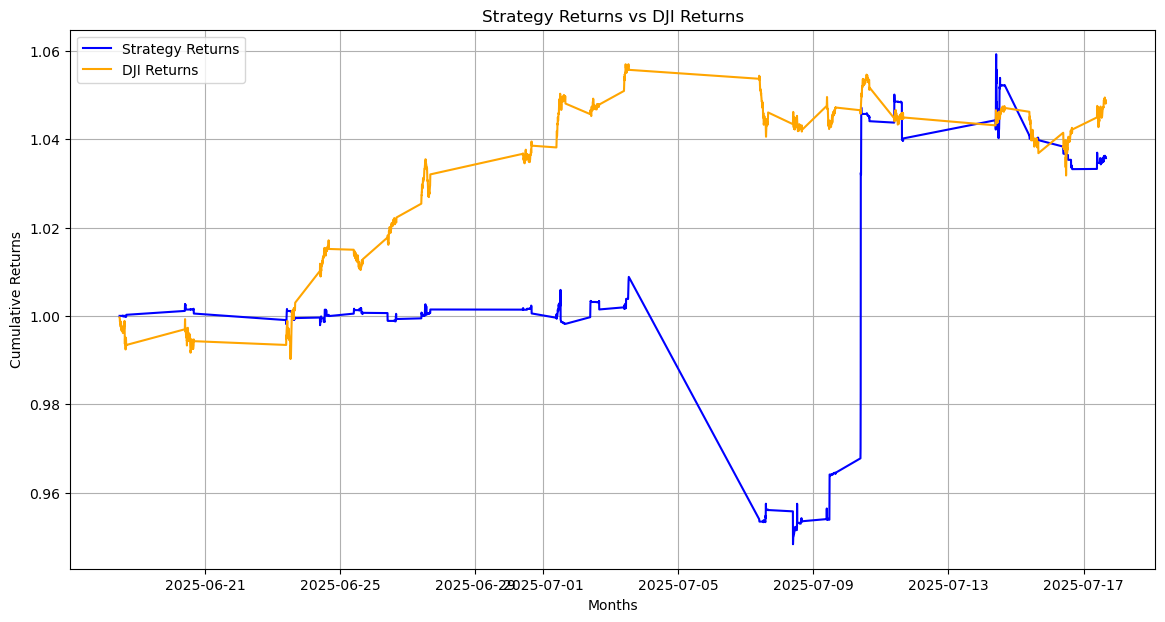

In [ ]:
DJI = get_intraday_data('^DJI')
DJI['Return'] = DJI['Adj Close'].pct_change()
DJI = DJI[20:]
print(f"DJI avg_return: {avg_return(DJI):.4f}")
print(f"DJI Volatility: {volatility(DJI):.4f}")
print(f"DJI Sharpe Ratio: {sharpe(DJI):.4f}")
print(len(DJI))


plt.figure(figsize=(14, 7))
plt.plot((1 + strategy_df['Return']).cumprod(), label='Strategy Returns', color='blue')
plt.plot((1 + DJI['Return']).cumprod(), label='DJI Returns', color='orange')
plt.title('Strategy Returns vs DJI Returns')
plt.xlabel('Months')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

Tracking trades

In [ ]:
from print_trades_table import print_trades_table
print_trades_table(trades)

Total Trades: 256

Ticker       Entry Date  Entry Price        Exit Date  Exit Price (Idealized)
  AMZN 2025-06-18 13:25     214.8350 2025-06-18 13:40                215.0496
  MSFT 2025-06-18 14:00     478.6600 2025-06-18 14:25                478.6344
  CSCO 2025-06-18 14:55      65.9000 2025-06-18 15:10                 66.0255
  NVDA 2025-06-18 15:50     145.4100 2025-06-20 09:30                145.0568
  CSCO 2025-06-18 15:50      65.8300 2025-06-20 09:30                 65.9929
  AMZN 2025-06-18 15:50     213.7250 2025-06-20 09:30                213.2162
  AAPL 2025-06-18 15:50     196.5000 2025-06-20 09:45                199.8854
  MSFT 2025-06-18 15:50     479.8050 2025-06-20 09:35                482.0004
  INTC 2025-06-18 15:50      21.4750 2025-06-20 10:15                 21.5539
    VZ 2025-06-18 15:55      41.6600 2025-06-20 09:30                 41.7106
  TSLA 2025-06-20 09:30     330.7550 2025-06-20 09:35                328.9248
  ABVE 2025-06-20 09:30       1.3060 2025-06-